Курсовой проект по курсу: Библиотеки Python для Data Science. Продоолжение
Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.
Метрика качества

F1-score (sklearn.metrics.f1_score)
Требования к решению

Целевая метрика: F1 > 0.5 Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)
Решение должно содержать

    Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
    Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv
    Рекомендации для файла с кодом (ipynb)
    Файл должен содержать заголовки и комментарии (markdown)
    Повторяющиеся операции лучше оформлять в виде функций
    Не делать вывод большого количества строк таблиц (5-10 достаточно)
    По возможности добавлять графики, описывающие данные (около 3-5)
    Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
    Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
    Весь проект должен быть в одном скрипте (файл ipynb).
    Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.


Примерное описание этапов выполнения курсового проекта

    Построение модели классификации
    Обзор обучающего датасета
    Обработка выбросов
    Обработка пропусков
    Анализ данных
    Отбор признаков
    Балансировка классов
    Подбор моделей, получение бейзлана
    Выбор наилучшей модели, настройка гиперпараметров
    Проверка качества, борьба с переобучением
    Интерпретация результатов

Прогнозирование на тестовом датасете

    Выполнить для тестового датасета те же этапы обработки и постронияния признаков
    Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
    Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
    Соблюдать исходный порядок примеров из тестового датасета

Обзор данных
Описание датасета

    Home Ownership - домовладение
    Annual Income - годовой доход
    Years in current job - количество лет на текущем месте работы
    Tax Liens - налоговые обременения
    Number of Open Accounts - количество открытых счетов
    Years of Credit History - количество лет кредитной истории
    Maximum Open Credit - наибольший открытый кредит
    Number of Credit Problems - количество проблем с кредитом
    Months since last delinquent - количество месяцев с последней просрочки платежа
    Bankruptcies - банкротства
    Purpose - цель кредита
    Term - срок кредита
    Current Loan Amount - текущая сумма кредита
    Current Credit Balance - текущий кредитный баланс
    Monthly Debt - ежемесячный долг
    Credit Score - кредитный рейтинг
    Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams.update({'font.size': 10})
%matplotlib inline

import pickle
import random
import xgboost as xgb
import catboost as catb
import lightgbm as lgbm
import scipy.stats as stats


from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve

# Алгоритмы кластеризации:

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

# Метрика F1:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# Статистика

from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import probplot
from scipy.stats import chi2_contingency
from pathlib import Path

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
df_train = pd.read_csv('course_project_train.csv')
df_test = pd.read_csv('course_project_test.csv')

In [3]:
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


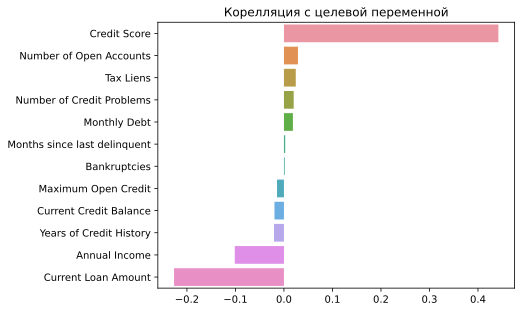

In [4]:
# Корелляция с целевой переменной
corr_with_target = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Корелляция с целевой переменной')
plt.show()

In [5]:
df_train.shape

(7500, 17)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [7]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,1987.0,1.366922e+06,9.171252e+05,106533.0,852311.50,1178475.0,1629734.5,14975610.0
Tax Liens,2500.0,3.520000e-02,3.862909e-01,0.0,0.00,0.0,0.0,15.0
Number of Open Accounts,2500.0,1.118440e+01,4.852774e+00,1.0,8.00,10.0,14.0,48.0
Years of Credit History,2500.0,1.832592e+01,7.254659e+00,3.9,13.40,17.0,22.1,53.4
Maximum Open Credit,2500.0,7.105704e+05,1.511983e+06,0.0,278586.00,478676.0,802598.5,54484386.0
Number of Credit Problems,2500.0,1.620000e-01,5.598941e-01,0.0,0.00,0.0,0.0,15.0
Months since last delinquent,1142.0,3.418126e+01,2.202428e+01,0.0,16.00,30.0,50.0,82.0
Bankruptcies,2497.0,1.069283e-01,3.571893e-01,0.0,0.00,0.0,0.0,5.0
Current Loan Amount,2500.0,1.215572e+07,3.226097e+07,15422.0,187126.50,322366.0,522582.5,99999999.0
Current Credit Balance,2500.0,2.963966e+05,3.783020e+05,0.0,110114.50,207385.0,366348.5,6030087.0


In [26]:
# Функция находит все признаки, в которых первое значение строка
def find_cat(df_train):
    for name in df_train.columns:
        s = ''
        s += name
        if (type(df_train[name][0]) == str):
            s += ' строка,'
        if (df_train[name].nunique()<=3):
            s += ' мало уникальных'
        if (s!=name):
            print (s)       
    
# Функция считает и выводит пропущенные значения столбцов датафрейма  
def mis_values_report(df_train):
    mis_val = df_train.isnull().sum()
    perc_mis_val = 100 * df_train.isnull().sum() / len(df_train)
    report = pd.concat([mis_val, perc_mis_val], axis=1)
    report_columns = report.rename(columns = {0: 'Пропущенные значения', 1: '% от всех значений'})
    report_columns = report_columns[report_columns.iloc[:,1] != 0].sort_values('% от всех значений', 
                                                                               ascending=False).round(1)
    print('Датафрейм имеет ' + str(df_train.shape[1]) + ' столбцов.\n' + str(report_columns.shape[0]) + 
          ' столбцов имеют пропущенные значения')
    return report_columns

def hst(target_name):
    plt.figure(figsize=(10,4))
    ax1 = plt.subplot(121)
    ax1.set_xlabel(target_name)
    ax1.set_ylabel('Count')
    ax1.set_title(f'{target_name} distribution')
    df_test[target_name].hist()
    plt.subplot(122)
    probplot(df_test[target_name],dist='norm',plot=plt)
    plt.show()

In [9]:
find_cat(df_train)

Home Ownership строка,
Purpose строка,
Term строка, мало уникальных
Credit Default мало уникальных


In [10]:
mis_values_report(df_train)

Датафрейм имеет 17 столбцов.
5 столбцов имеют пропущенные значения


,Пропущенные значения,% от всех значений
Months since last delinquent,4081,54.4
Annual Income,1557,20.8
Credit Score,1557,20.8
Years in current job,371,4.9
Bankruptcies,14,0.2


In [11]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NUMB_FEATURE_NAMES = ['Annual Income','Tax Liens','Number of Open Accounts','Years of Credit History',
                     'Maximum Open Credit','Number of Credit Problems','Months since last delinquent',
                     'Bankruptcies','Current Loan Amount','Current Credit Balance','Monthly Debt','Credit Score']
CAT_FEATURE_NAMES = ['Years in current job','Home Ownership','Purpose','Term']

In [12]:
y = df_train[[TARGET_NAME]]
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Credit Default  7500 non-null   int64
dtypes: int64(1)
memory usage: 58.7 KB


In [13]:
df_train['ID'] = df_train.index.tolist()

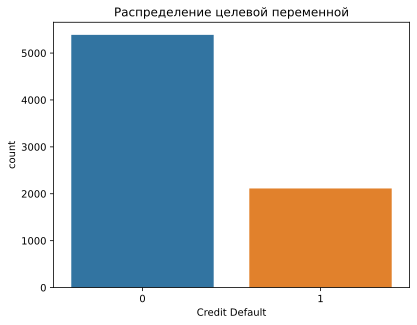

In [14]:
# Распределение целевой переменной
sns.countplot(x=TARGET_NAME, data=df_train)
plt.title('Распределение целевой переменной')
plt.show()

In [15]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
ID                                 0
dtype: int64

In [16]:
df_test.isna().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [17]:
df_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

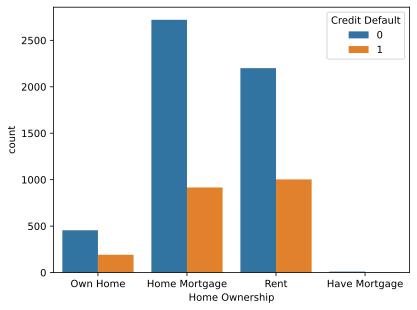

In [18]:
sns.countplot(x='Home Ownership', hue='Credit Default', data=df_train)
plt.show()

In [19]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['Home Ownership'], prefix='Home Ownership')], axis=1)
# Добавляем признаки в тестовый датасет
df_test = pd.concat([df_test, pd.get_dummies(df_test['Home Ownership'], prefix='Home Ownership')], axis=1)

In [20]:
df_train['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

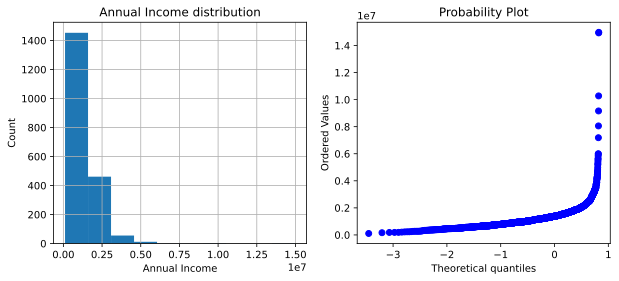

In [27]:
hst('Annual Income')

In [28]:
# Добавляется новый бинарный признак о неизвестном доходе 1/0 (доход известен/доход не известен)
df_train['unknown_income'] = 0
df_train.loc[(df_train['Annual Income'].isnull()), 'unknown_income'] = 1

# В новую переменную annual_income_median записывается медианное значение дохода
annual_income_median = df_train['Annual Income'].median()

# Пропуски дохода заполняются медианным значением
df_train['Annual Income'].fillna(annual_income_median, inplace=True)

# Добавляем признаки в тестовый датасет
df_test['unknown_income'] = 0
annual_income_median = df_test['Annual Income'].median()
df_test.loc[(df_test['Annual Income'].isnull()), 'unknown_income'] = 1
df_test['Annual Income'].fillna(annual_income_median, inplace=True)

In [29]:
# Добавляется новый бинарный признак - 1/0 (задолженость/отсутствие задолженности)
df_train['has_delay'] = 1
df_train.loc[(df_train['Months since last delinquent'] == 0), 'has_delay'] = 0

# Заменяется пропуск NaN на 0 в 'Months since last delinquent'
df_train['Months since last delinquent'].fillna(0, inplace=True)

# Добавляем признаки в тестовый датасет
df_test['has_delay'] = 1
df_test['Months since last delinquent'].fillna(0, inplace=True)
df_test.loc[(df_test['Months since last delinquent'] == 0), 'has_delay'] = 0

In [30]:
NEW_FEATURE_NAMES = ['has_delay','unknown_income']

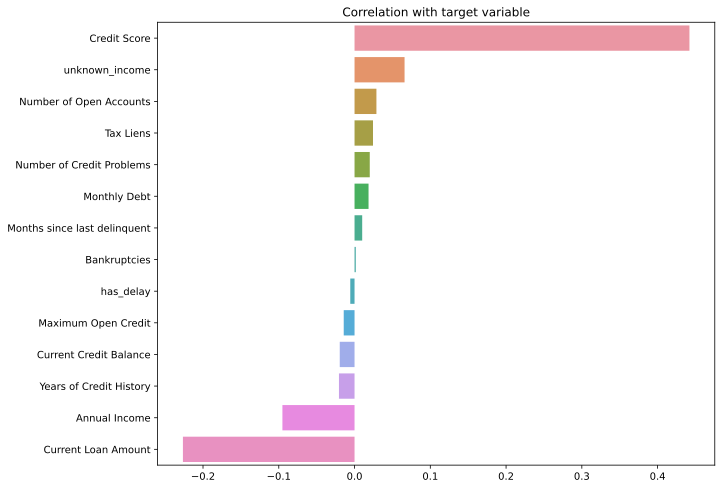

In [31]:
corr_with_target = df_train[BASE_FEATURE_NAMES + 
                            NEW_FEATURE_NAMES + 
                            [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [32]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                      0
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent       0
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
ID                                 0
Home Ownership_Have Mortgage       0
Home Ownership_Home Mortgage       0
Home Ownership_Own Home            0
Home Ownership_Rent                0
unknown_income                     0
has_delay                          0
dtype: int64

In [33]:
df_train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

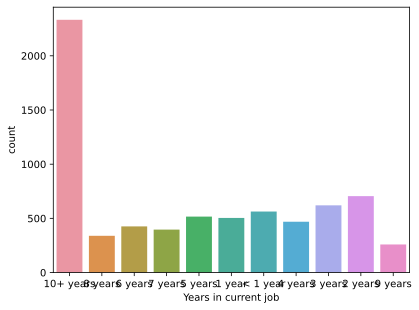

In [34]:
sns.countplot(x="Years in current job", data=df_train)
plt.show()

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Years in current job', ylabel='count'>

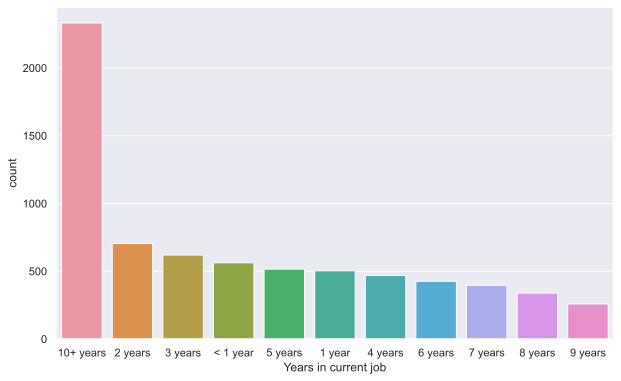

In [35]:
# посмотрим как выглядит распределение от стажа на месте
sns.set(style='darkgrid')
plt.figure(figsize=(10,6))
sns.countplot(df_train['Years in current job'], order = df_train['Years in current job'].value_counts().index)

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


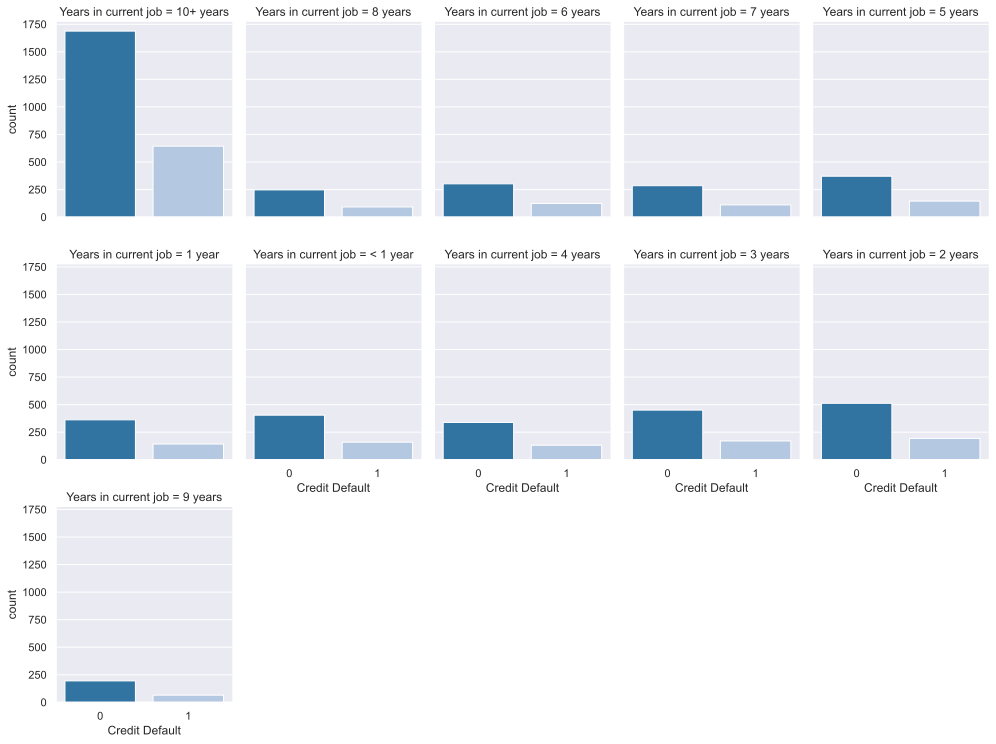

In [36]:
# Определение количества людей, в группах по стажу работы, не возвращающих кредит
g = sns.catplot("Credit Default", col="Years in current job", col_wrap=5,
                data=df_train,
                kind="count", height=3.5, aspect=.8, 
                palette='tab20')

#fig.suptitle('sf')
plt.show()

In [37]:
# Уникальные значения Years in current job
unique_years_in_current_job = df_train['Years in current job'].unique()

var_experiance = unique_years_in_current_job[1:]

# NaN заменяется на рандомный опыт
df_train['Years in current job'].fillna(random.choice(var_experiance), inplace=True)

# Добавляем признаки в тестовый датасет

unique_years_in_current_job = df_test['Years in current job'].unique()
var_experiance = unique_years_in_current_job[1:]
df_test['Years in current job'].fillna(random.choice(var_experiance), inplace=True)

In [38]:
df_train.isnull().sum()

Home Ownership                     0
Annual Income                      0
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent       0
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
ID                                 0
Home Ownership_Have Mortgage       0
Home Ownership_Home Mortgage       0
Home Ownership_Own Home            0
Home Ownership_Rent                0
unknown_income                     0
has_delay                          0
dtype: int64

In [39]:
df_train['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

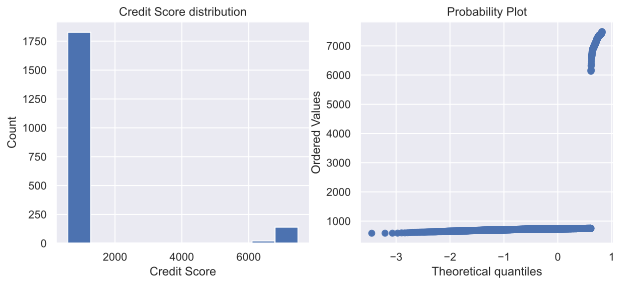

In [40]:
hst('Credit Score')

In [41]:
# Добавляется новая переменная unknown_credit_score по неизвестному Credit Score с присвоением 0 всем наблюдениям 
df_train['unknown_credit_score'] = 0

NEW_FEATURE_NAMES = ['has_delay','unknown_income','unknown_credit_score']

# В переменную credit_score_median записывается медианное значение рейтинга
credit_score_median = df_train['Credit Score'].median()

# По известному кредитному рейтингу присваивается 1 в переменной unknown_credit_score
df_train.loc[(df_train['Credit Score'].isnull()), 'unknown_credit_score'] = 1

# Пропуски рейтинга заполняются медианным значением
df_train['Credit Score'].fillna(credit_score_median, inplace=True)


# Добавляем признаки в тестовый датасет
df_test['unknown_credit_score'] = 0
NEW_FEATURE_NAMES = ['has_delay','unknown_income','unknown_credit_score']
credit_score_median = df_test['Credit Score'].median()
df_test.loc[(df_test['Credit Score'].isnull()), 'unknown_credit_score'] = 1
df_test['Credit Score'].fillna(credit_score_median, inplace=True)

In [42]:
df_train.isnull().sum()

Home Ownership                   0
Annual Income                    0
Years in current job             0
Tax Liens                        0
Number of Open Accounts          0
Years of Credit History          0
Maximum Open Credit              0
Number of Credit Problems        0
Months since last delinquent     0
Bankruptcies                    14
Purpose                          0
Term                             0
Current Loan Amount              0
Current Credit Balance           0
Monthly Debt                     0
Credit Score                     0
Credit Default                   0
ID                               0
Home Ownership_Have Mortgage     0
Home Ownership_Home Mortgage     0
Home Ownership_Own Home          0
Home Ownership_Rent              0
unknown_income                   0
has_delay                        0
unknown_credit_score             0
dtype: int64

In [43]:
df_train['Current Loan Amount'].value_counts()

99999999.0    870
218064.0        6
89298.0         6
222926.0        5
265826.0        5
             ... 
351626.0        1
212498.0        1
187682.0        1
108922.0        1
26928.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

In [44]:
df_train['Current Loan Amount'].describe()

count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

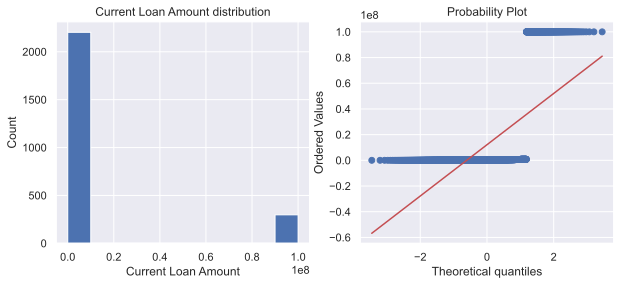

In [45]:
hst('Current Loan Amount')

In [46]:
# 99999999.0 в Current Loan Amount заменяются на медианные
median_current_loan_amount = df_train['Current Loan Amount'].median()
df_train.loc[(df_train['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'] = median_current_loan_amount

# Добавляем признаки в тестовый датасет
median_current_loan_amount = df_test['Current Loan Amount'].median()
df_test.loc[(df_test['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'] = median_current_loan_amount

In [47]:
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [48]:
df_train['Bankruptcies'].fillna(0 , inplace=True)

In [49]:
df_train.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
ID                              0
Home Ownership_Have Mortgage    0
Home Ownership_Home Mortgage    0
Home Ownership_Own Home         0
Home Ownership_Rent             0
unknown_income                  0
has_delay                       0
unknown_credit_score            0
dtype: int64

In [50]:
df_train['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

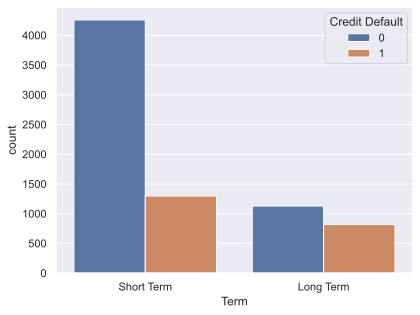

In [51]:
sns.countplot(x="Term", hue='Credit Default', data=df_train)
plt.show()

In [52]:
df_train['Term'] = df_train['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(float)

# Добавляем признаки в тестовый датасет
df_test['Term'] = df_test['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(float)

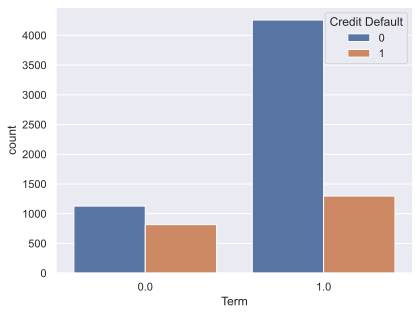

In [53]:
sns.countplot(x="Term", hue='Credit Default', data=df_train)
plt.show()

In [54]:
def corr_(val, x1, x2):
    pay1_and_target_s = df_train.loc[df_train[val].isin([x1, x2]), ['ID', val, 'Credit Default']]#.sample(1000)
    table = pay1_and_target_s.pivot_table(values='ID', index=val, columns='Credit Default', aggfunc='count')
    chi2, p, dof, expected = chi2_contingency(table, correction=False)
    print(p)

corr_('Term',0,1)

1.1519373940439208e-55


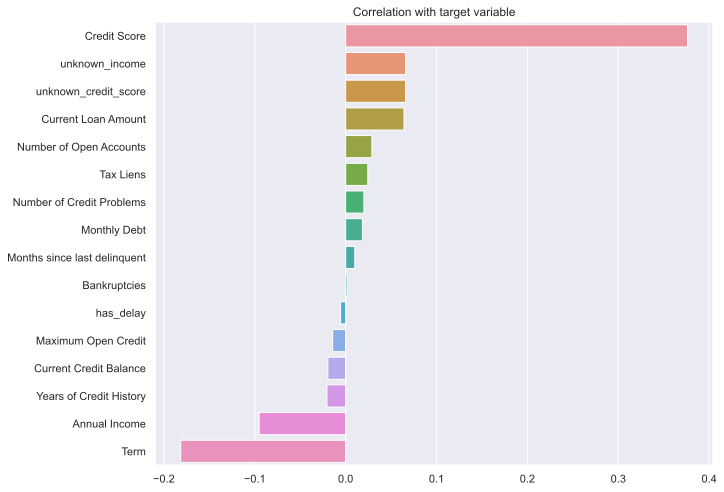

In [55]:
corr_with_target = df_train[BASE_FEATURE_NAMES + 
                            NEW_FEATURE_NAMES + 
                            [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [56]:
df_train.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
ID                              0
Home Ownership_Have Mortgage    0
Home Ownership_Home Mortgage    0
Home Ownership_Own Home         0
Home Ownership_Rent             0
unknown_income                  0
has_delay                       0
unknown_credit_score            0
dtype: int64

In [57]:
df_train['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

In [58]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

<AxesSubplot:>

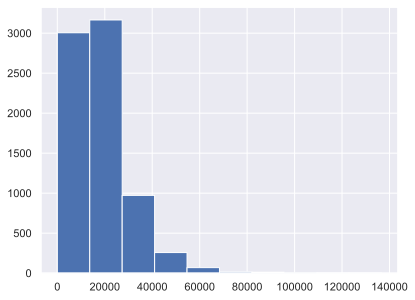

In [59]:
df_train['Monthly Debt'].hist()

<AxesSubplot:>

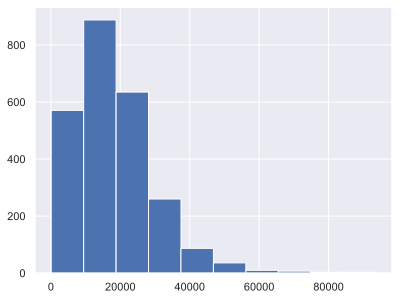

In [60]:
df_test['Monthly Debt'].hist()

In [61]:
df_train.loc[df_train['Monthly Debt'] > df_train['Monthly Debt'].quantile(.99), \
       ['Monthly Debt']] = df_train['Monthly Debt'].mean()

# Добавляем признаки в тестовый датасет
df_test.loc[df_test['Monthly Debt'] > df_test['Monthly Debt'].quantile(.99), \
       ['Monthly Debt']] = df_test['Monthly Debt'].mean()

<AxesSubplot:>

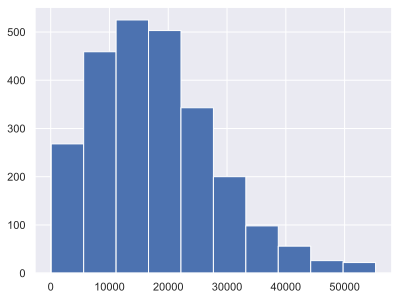

In [62]:
df_test['Monthly Debt'].hist()

In [63]:
df_train['Current Credit Balance'].describe()

count    7.500000e+03
mean     2.898332e+05
std      3.178714e+05
min      0.000000e+00
25%      1.142565e+05
50%      2.093230e+05
75%      3.604062e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

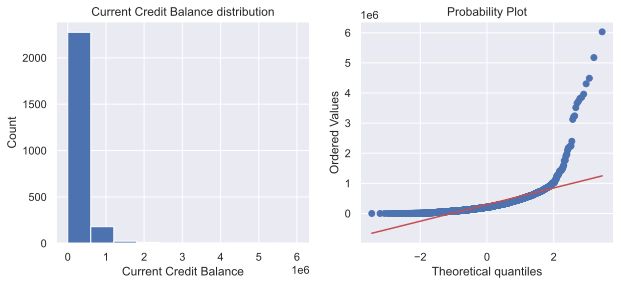

In [64]:
hst('Current Credit Balance')

In [65]:
#считаем выбросы
df_train.loc[df_train['Current Credit Balance'] > df_train['Current Credit Balance'].quantile(.95), :].shape

(375, 25)

In [66]:
df_train.loc[df_train['Current Credit Balance'] > df_train['Current Credit Balance'].quantile(.95), \
       ['Current Credit Balance']] = df_train['Current Credit Balance'].quantile(.95) 
# Добавляем признаки в тестовый датасет
df_test.loc[df_test['Current Credit Balance'] > df_test['Current Credit Balance'].quantile(.95), \
       ['Current Credit Balance']] = df_test['Current Credit Balance'].quantile(.95) 

<AxesSubplot:>

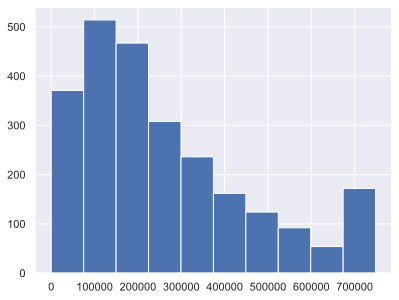

In [67]:
df_test['Current Credit Balance'].hist()

In [68]:
df_test['Purpose'].value_counts()

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving                     1
Name: Purpose, dtype: int64

<AxesSubplot:title={'center':'Purpose'}>

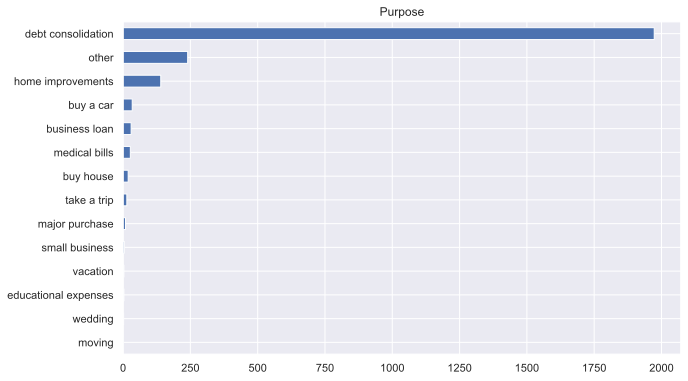

In [69]:
df_test['Purpose'].value_counts().sort_values(ascending=True).plot(kind='barh', title='Purpose', figsize=(10,6))

In [70]:
df_train['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

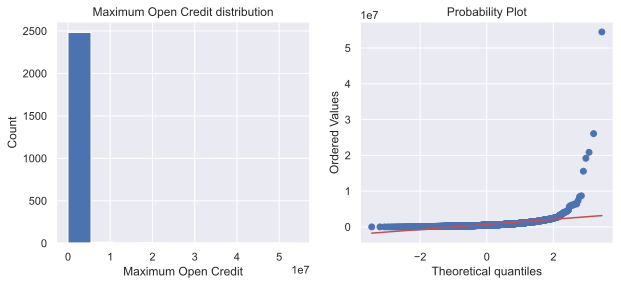

In [71]:
hst('Maximum Open Credit')

In [72]:
df_train.loc[df_train['Maximum Open Credit'] > df_train['Maximum Open Credit'].quantile(.95), ['Maximum Open Credit']] =\
            df_train['Maximum Open Credit'].quantile(.95)
# Добавляем признаки в тестовый датасет
df_test.loc[df_test['Maximum Open Credit'] > df_test['Maximum Open Credit'].quantile(.95), ['Maximum Open Credit']] =\
            df_test['Maximum Open Credit'].quantile(.95)

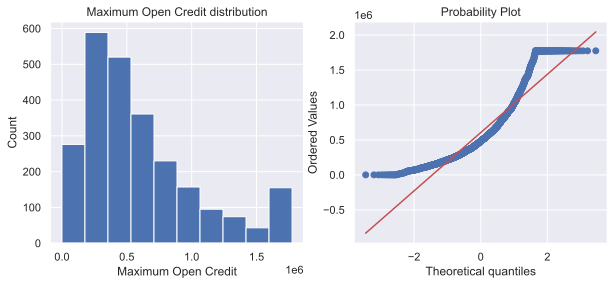

In [73]:
hst('Maximum Open Credit')

In [74]:
df_train['Years of Credit History'].value_counts()

15.0    104
16.0     99
16.5     91
17.0     86
17.5     83
       ... 
44.0      1
39.8      1
40.0      1
39.9      1
48.3      1
Name: Years of Credit History, Length: 408, dtype: int64

<AxesSubplot:>

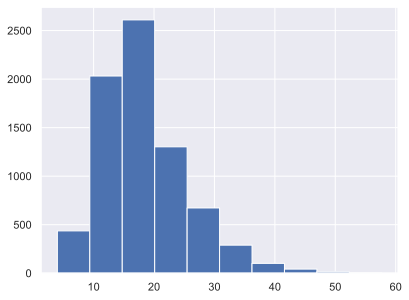

In [75]:
df_train['Years of Credit History'].hist()

In [76]:
df_train.loc[df_train['Years of Credit History'] > 40, ['Years of Credit History']] = 40
# Добавляем признаки в тестовый датасет
df_test.loc[df_test['Years of Credit History'] > 40, ['Years of Credit History']] = 40

In [77]:
df_train['Years of Credit History'].value_counts()

15.0    104
16.0     99
16.5     91
17.0     86
40.0     84
       ... 
4.9       1
36.3      1
6.2       1
38.5      1
34.7      1
Name: Years of Credit History, Length: 350, dtype: int64

<AxesSubplot:>

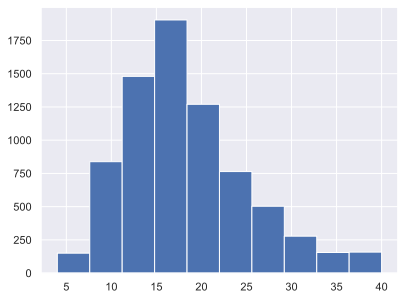

In [78]:
df_train['Years of Credit History'].hist()

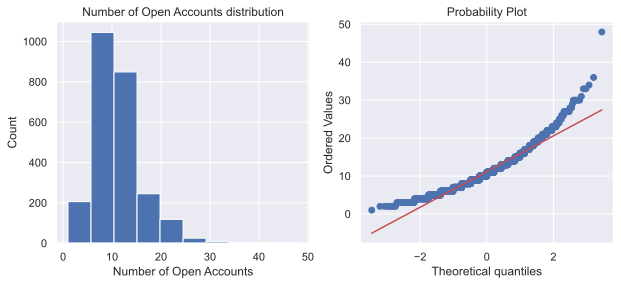

In [79]:
hst('Number of Open Accounts')

In [80]:
df_train.loc[df_train['Number of Open Accounts'] > 
             df_train['Number of Open Accounts'].quantile(.95), ['Number of Open Accounts']] =\
            df_train['Number of Open Accounts'].median()
# Добавляем признаки в тестовый датасет
df_test.loc[df_test['Number of Open Accounts'] > df_test['Number of Open Accounts'].quantile(.95),  \
            ['Number of Open Accounts']] = df_test['Number of Open Accounts'].median()

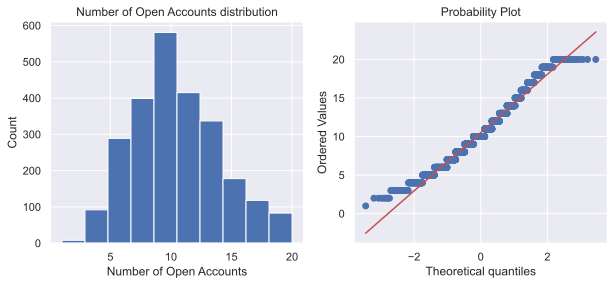

In [81]:
hst('Number of Open Accounts')

In [82]:
df_train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

#### В итоге:

In [83]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   float64
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [84]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))


def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [85]:
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Credit Score,Credit Default,ID,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,unknown_income,has_delay,unknown_credit_score
0,Own Home,482087.0,9 years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,...,749.0,0,0,0,0,1,0,0,1,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,...,737.0,1,1,0,0,1,0,0,1,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,...,742.0,0,2,0,1,0,0,0,1,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,...,694.0,0,3,0,0,1,0,0,1,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,...,719.0,0,4,0,0,0,1,0,1,0
5,Rent,1168386.0,7 years,0.0,12.0,14.6,366784.0,0.0,0.0,0.0,...,731.0,1,5,0,0,0,1,1,1,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,...,745.0,0,6,0,1,0,0,0,1,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,...,705.0,1,7,0,0,0,1,0,1,0
8,Home Mortgage,1168386.0,5 years,0.0,17.0,15.7,0.0,1.0,0.0,1.0,...,731.0,0,8,0,1,0,0,1,1,1
9,Home Mortgage,1168386.0,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,...,731.0,1,9,0,1,0,0,1,1,1


In [86]:
NEW_FEATURE_NAMES

['has_delay', 'unknown_income', 'unknown_credit_score']

In [87]:
SELECTED_FEATURE_NAMES = NUMB_FEATURE_NAMES + NEW_FEATURE_NAMES


X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=43)

Нормализация

In [88]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUMB_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMB_FEATURE_NAMES])

df_train = df_norm.copy()

Балансировка

In [89]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

C:\Users\xiaomi\AppData\Local\Temp\ipykernel_10184\2561343080.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sample, ignore_index=True)


0    3795
1    2910
Name: Credit Default, dtype: int64

In [90]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

#### CatBoost

In [148]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=43)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      0.56      0.72      3795
           1       0.64      1.00      0.78      2910

    accuracy                           0.75      6705
   macro avg       0.82      0.78      0.75      6705
weighted avg       0.84      0.75      0.74      6705

TEST

              precision    recall  f1-score   support

           0       0.86      0.45      0.59      1592
           1       0.38      0.83      0.52       658

    accuracy                           0.56      2250
   macro avg       0.62      0.64      0.56      2250
weighted avg       0.72      0.56      0.57      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               720  872
1               114  544


In [149]:
model_catb = catb.CatBoostClassifier(class_weights=[1.5, 3.5], silent=True, random_state=43)

In [150]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000],
          'max_depth':[3, 5, 7, 9]}

In [151]:
cv=KFold(n_splits=3, random_state=43, shuffle=True)

In [152]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv)
rs.fit(X, y)

Wall time: 1min 51s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=43, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x00000175A55194F0>,
                   param_distributions={'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000]},
                   scoring='f1')

In [153]:
rs.best_params_

{'n_estimators': 50, 'max_depth': 5}

In [154]:
rs.best_score_

0.5253628167255063

In [160]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=rs.best_params_['n_estimators'], 
                                      max_depth=rs.best_params_['max_depth'],
                                      silent=True, random_state=43, class_weights=[1, 1.1])
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.83      0.80      3795
           1       0.76      0.68      0.72      2910

    accuracy                           0.77      6705
   macro avg       0.76      0.76      0.76      6705
weighted avg       0.77      0.77      0.76      6705

TEST

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1592
           1       0.51      0.53      0.52       658

    accuracy                           0.71      2250
   macro avg       0.65      0.66      0.66      2250
weighted avg       0.72      0.71      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1250  342
1                308  350
Wall time: 139 ms


#### xgboost.XGBClassifier

In [121]:
model_XGB = XGBClassifier(random_state=43)
model_XGB.fit(X_train, y_train)

y_train_pred = model_XGB.predict(X_train)
y_test_pred = model_XGB.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3795
           1       0.99      0.98      0.98      2910

    accuracy                           0.99      6705
   macro avg       0.99      0.99      0.99      6705
weighted avg       0.99      0.99      0.99      6705

TEST

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1592
           1       0.53      0.43      0.47       658

    accuracy                           0.72      2250
   macro avg       0.66      0.64      0.64      2250
weighted avg       0.71      0.72      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1343  249
1                376  282


In [122]:
cv=KFold(n_splits=3, random_state=43, shuffle=True)
params = {'n_estimators':[50, 100, 200, 500, 700, 1000],
          'max_depth':[3, 5, 7],
         'learning_rate':[0.01, 0.001, 0.1]}

In [123]:
%%time

rs = RandomizedSearchCV(model_XGB, params, scoring='f1', cv=cv)
rs.fit(X, y)

Wall time: 52.9 s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=43, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=No...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                  

In [124]:
rs.best_params_

{'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}

In [125]:
rs.best_score_

0.42794720245652007

In [127]:
final_model_XGB = catb.CatBoostClassifier(n_estimators=rs.best_params_['n_estimators'], 
                                          max_depth=rs.best_params_['max_depth'], 
                                          learning_rate=rs.best_params_['learning_rate'],
                                           silent=True, random_state=43)
final_model_XGB.fit(X_train, y_train)

y_train_pred = final_model_XGB.predict(X_train)
y_test_pred = final_model_XGB.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      3795
           1       0.95      0.87      0.91      2910

    accuracy                           0.92      6705
   macro avg       0.93      0.92      0.92      6705
weighted avg       0.92      0.92      0.92      6705

TEST

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1592
           1       0.58      0.44      0.50       658

    accuracy                           0.74      2250
   macro avg       0.68      0.65      0.66      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1378  214
1                368  290


#### AdaBoostClassifier

In [128]:
model_Ada = AdaBoostClassifier(random_state=43)
model_Ada.fit(X_train, y_train)

y_train_pred = model_Ada.predict(X_train)
y_test_pred = model_Ada.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.83      0.76      3795
           1       0.71      0.53      0.61      2910

    accuracy                           0.70      6705
   macro avg       0.70      0.68      0.68      6705
weighted avg       0.70      0.70      0.69      6705

TEST

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      1592
           1       0.52      0.49      0.51       658

    accuracy                           0.72      2250
   macro avg       0.66      0.65      0.66      2250
weighted avg       0.72      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1297  295
1                333  325


In [129]:
cv=KFold(n_splits=3, random_state=43, shuffle=True)
params = {'n_estimators':[50, 100, 200, 500, 700, 1000],
         'learning_rate':[0.01, 0.001, 0.1]}

In [130]:
%%time

rs = RandomizedSearchCV(model_Ada, params, scoring='f1', cv=cv)
rs.fit(X, y)

Wall time: 1min 10s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=43, shuffle=True),
                   estimator=AdaBoostClassifier(random_state=43),
                   param_distributions={'learning_rate': [0.01, 0.001, 0.1],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000]},
                   scoring='f1')

In [131]:
rs.best_params_

{'n_estimators': 1000, 'learning_rate': 0.1}

In [132]:
rs.best_score_

0.3743361710334187

In [133]:
final_model_Ada = catb.CatBoostClassifier(n_estimators=rs.best_params_['n_estimators'],  
                                          learning_rate=rs.best_params_['learning_rate'],
                                          silent=True, random_state=43)
final_model_Ada.fit(X_train, y_train)

y_train_pred = final_model_Ada.predict(X_train)
y_test_pred = final_model_Ada.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3795
           1       1.00      1.00      1.00      2910

    accuracy                           1.00      6705
   macro avg       1.00      1.00      1.00      6705
weighted avg       1.00      1.00      1.00      6705

TEST

              precision    recall  f1-score   support

           0       0.77      0.87      0.82      1592
           1       0.55      0.38      0.45       658

    accuracy                           0.73      2250
   macro avg       0.66      0.63      0.64      2250
weighted avg       0.71      0.73      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1392  200
1                409  249


#### RandomForestClassifier

In [134]:
model_RFC = RandomForestClassifier(random_state=43)
model_RFC.fit(X_train, y_train)

y_train_pred = model_RFC.predict(X_train)
y_test_pred = model_RFC.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3795
           1       1.00      1.00      1.00      2910

    accuracy                           1.00      6705
   macro avg       1.00      1.00      1.00      6705
weighted avg       1.00      1.00      1.00      6705

TEST

              precision    recall  f1-score   support

           0       0.77      0.94      0.85      1592
           1       0.68      0.33      0.44       658

    accuracy                           0.76      2250
   macro avg       0.73      0.63      0.64      2250
weighted avg       0.74      0.76      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1490  102
1                442  216


In [135]:
cv=KFold(n_splits=3, random_state=43, shuffle=True)
params = {'n_estimators':[50, 100, 200, 500, 700, 1000],
          'max_depth':[3, 5, 7]}

In [136]:
%%time

rs = RandomizedSearchCV(model_RFC, params, scoring='f1', cv=cv)
rs.fit(X, y)

Wall time: 59.6 s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=43, shuffle=True),
                   estimator=RandomForestClassifier(random_state=43),
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000]},
                   scoring='f1')

In [137]:
rs.best_params_

{'n_estimators': 500, 'max_depth': 7}

In [138]:
rs.best_score_

0.32457617176144465

#### ВЫВОД:

Лучшая модель - это CatBoost

In [161]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=50, 
                                      max_depth=5,
                                      silent=True, 
                                      random_state=43, 
                                      class_weights=[1, 1.1])
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.83      0.80      3795
           1       0.76      0.68      0.72      2910

    accuracy                           0.77      6705
   macro avg       0.76      0.76      0.76      6705
weighted avg       0.77      0.77      0.76      6705

TEST

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1592
           1       0.51      0.53      0.52       658

    accuracy                           0.71      2250
   macro avg       0.65      0.66      0.66      2250
weighted avg       0.72      0.71      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1250  342
1                308  350
Wall time: 175 ms


In [162]:
df_for_model = df_test[SELECTED_FEATURE_NAMES]
df_for_model.head(10)

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,has_delay,unknown_income,unknown_credit_score
0,1178475.0,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,162470.0,105906.0,6813.0,731.0,1,1,1
1,231838.0,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,78298.0,46037.0,2318.0,699.0,1,0,0
2,1152540.0,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,200178.0,146490.0,18729.0,7260.0,0,0,0
3,1220313.0,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,217382.0,213199.0,27559.0,739.0,1,0,0
4,2340952.0,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,777634.0,425391.0,42605.0,706.0,0,0,0
5,922583.0,0.0,10.0,17.5,713174.0,0.0,41.0,0.0,94028.0,135508.0,11148.0,679.0,1,0,0
6,1233309.0,0.0,7.0,22.0,376420.0,0.0,43.0,0.0,454388.0,292904.0,8181.0,685.0,1,0,0
7,1215867.0,0.0,13.0,12.2,195888.0,0.0,19.0,0.0,407726.0,120099.0,7599.0,701.0,1,0,0
8,1178475.0,0.0,8.0,9.1,370524.0,0.0,0.0,0.0,131956.0,237747.0,10112.0,731.0,0,1,1
9,2140445.0,1.0,15.0,16.7,867680.0,1.0,9.0,0.0,391336.0,294500.0,18372.0,745.0,1,0,0


In [163]:
y_pred_output = final_model.predict(df_for_model)

In [164]:
y_pred_output.shape

(2500,)

In [165]:
result=pd.DataFrame({'Id':np.arange(2500), 'Credit Default': y_pred_output})

In [166]:
result

,Id,Credit Default
0,0,0
1,1,1
2,2,1
3,3,0
4,4,0
...,...,...
2495,2495,0
2496,2496,1
2497,2497,1
2498,2498,0


In [167]:
RESULT_PATH='./Alexandr_Kasjanov_predictions.csv'
result.to_csv(RESULT_PATH, index=False)

1. Как работает регуляризация в решающих деревьях какие параметры мы штрафуем в данных алгоритмах?

Регуляризация по технике «Лассо» (L1)
«Лассо» штрафует весовые коэффициенты модели в целях изменения их важности для модели, причем возможно даже полное их обнуление (речь идет о том, чтобы убрать из конечной модели эти переменные). Как правило, «Лассо» применяется, когда набор данных включает в себя очень много переменных и надо исключить некоторые из этих переменных, дабы лучше понять, как именно важные признаки влияют на нашу модель (т. е. речь идет о признаках, которые были выбраны с помощью техники «Лассо» и у которых определена важность).
Регуляризация по технике Ridge (L2)
Задача Ridge — сохранить все переменные и в то же самое время присвоить им важность на основании вклада в эффективность модели. Ridge — хороший выбор в том случае, когда набор данных включает в себя немного переменных, причем все эти переменные нужны для интерпретации полученных результатов.
Elastic-Net
Таким образом, техника Ridge оставляет все переменные, а техника «Лассо» более эффективно устанавливает их важность. На основании этого был создан специальный алгоритм, объединивший в себе преимущества обеих техник регуляризации. Этот алгоритм называют Elastic-Net. Реализовать его можно посредством перекрестной валидации sklearn.
Конечно, в машинном обучении существуют и другие способы отбора признаков, однако главная идея не меняется: продемонстрировать важность переменных, а потом исключить некоторые из переменных на основе полученных показателей важности. При этом важность — термин субъективный, представляющий собой целый перечень метрик и диаграмм, который можно применять при нахождении ключевых признаков.


2. По какому принципу рассчитывается "важность признака (feature_importance)" в ансамблях деревьев?

Относительный ранг (то есть глубина) признака, используемого в качестве узла принятия решения в дереве, может использоваться для оценки относительной важности этого признака по отношению к предсказуемости целевой переменной. Элементы, используемые в верхней части дерева, участвуют в окончательном решении прогнозирования большей части входных выборок. Таким образом, ожидаемая доля выборок, в которые они вносят вклад, может использоваться как оценка относительной важности характеристик . В scikit-learn доля выборок, в которую вносит свой вклад функция, сочетается с уменьшением примесей от их разделения для создания нормализованной оценки предсказательной силы этой функции.

Усредняя оценки прогностической способности по нескольким рандомизированным деревьям, можно уменьшить дисперсию такой оценки и использовать ее для выбора признаков . Это известно как среднее уменьшение содержания примесей или MDI. 

Важность признаков на основе примесей, вычисленная на основе древовидных моделей, страдает двумя недостатками, которые могут привести к ошибочным выводам. Сначала они вычисляются на основе статистики, полученной из набора обучающих данных, и поэтому не обязательно информируют нас о том, какие функции наиболее важны для того, чтобы делать хорошие прогнозы на удерживаемом наборе данных . Во-вторых, они отдают предпочтение характеристикам с высокой мощностью , то есть функциям с множеством уникальных значений. Важность перестановки признаков - это альтернатива важности признаков на основе примесей, которая не страдает этими недостатками. Эти два метода получения важности функции исследуются в разделе «Важность перестановки против важности случайной характеристики леса» (MDI) .